## Analysis of Sequencing Data

Here I use ScanPy to analyse sequencing data from our experiments as well as some existing single cell aging data from the Tabula Muris Senis Consortium.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy.stats as st
import sys, os
import seaborn as sns

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

### Reading Data

Reading data from count tables. Those are .h5ad format and are provided from Xpress Genomics as well as are publicly available from figshare for the Tabula Muris Consortium. From the latter I retrieved two data sets: one form general non-myeloid brain tissue and one from general myeloid brain tissue.

In [2]:
folder = r"C:\Users\Johann\Documents\Coding\Master Thesis\Data"
file_paths = []
for file_name in os.listdir(folder):
    file_paths.append(os.path.join(folder, file_name))

data = {}
for file in file_paths:
    data.update(dict([(file.strip(".h5ad").split("\\")[-1], file)]))

for key, value in data.items():
    print(key, "->\t", value)

CBA_12mo_SGN ->	 C:\Users\Johann\Documents\Coding\Master Thesis\Data\CBA_12mo_SGN.h5ad
CBA_24mo_SGN ->	 C:\Users\Johann\Documents\Coding\Master Thesis\Data\CBA_24mo_SGN.h5ad
CBA_3mo_SGN ->	 C:\Users\Johann\Documents\Coding\Master Thesis\Data\CBA_3mo_SGN.h5ad
CBA_9mo_OC_SGN_TestPlates ->	 C:\Users\Johann\Documents\Coding\Master Thesis\Data\CBA_9mo_OC_SGN_TestPlates.h5ad
TMS_Brain_Myeloi ->	 C:\Users\Johann\Documents\Coding\Master Thesis\Data\TMS_Brain_Myeloid.h5ad
TMS_Brain_Nonmyeloi ->	 C:\Users\Johann\Documents\Coding\Master Thesis\Data\TMS_Brain_Nonmyeloid.h5ad


In [3]:
adata = sc.read_h5ad(data["CBA_3mo_SGN"])
adata.obs_names_make_unique()
adata.obs["sample"] = "3 months"
del adata.obs["barcode"]
del adata.obs["orig-ident"]
del adata.obs["nCount_RNA"]
del adata.obs["nFeature_RNA"]

# Retrieve the list of plate IDs that were used for this data set
adata.uns["plate_IDs"] = set(adata.obs["plate"].to_list())
adata.uns["sample"] = "3 Months"
adata.uns["project"] = "CBA Cochlea Atlas Lallemend"
adata.uns["tissue"] = "Spiral Ganglion"

adata

AnnData object with n_obs × n_vars = 5476 × 27586
    obs: 'sample', 'plate'
    uns: 'plate_IDs', 'sample', 'project', 'tissue'

In [4]:
# This table doesnt contain ribosomal genes, mnakes sense because single nuclei
# However mitochondrial genes are included
adata.var["mt"] = adata.var_names.str.startswith(("mt-"))
adata.var

,mt
0610005C13Rik,False
0610009B22Rik,False
0610009E02Rik,False
0610009L18Rik,False
0610010K14Rik,False
...,...
Tbx21,False
Tex43,False
Usp51,False
Vmn2r26,False


In [5]:
sc.pp.calculate_qc_metrics(adata, qc_vars= ["mt"],
                           percent_top= [20],
                           inplace= True)

adata.obs
# adata.var

,sample,plate,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
barcode,,,,,,,,,,
AACCACATCGAACGCCTCGA,3 months,11101383,682,6.526495,768,6.645091,7.682292,2,1.098612,0.260417
AACCACATCGACAACTCGAA,3 months,11101383,1556,7.350516,2764,7.924796,9.334298,5,1.791759,0.180897
AACCACATCGAGGTGTCGAG,3 months,11101383,2468,7.811568,4731,8.462103,7.440287,16,2.833213,0.338195
AACCACATCGATCCAAGGAA,3 months,11101383,2056,7.629004,3173,8.062748,12.133627,5,1.791759,0.157580
AACCACATCGCACGGTGGTT,3 months,11101383,3597,8.188133,10149,9.225229,11.656321,4,1.609438,0.039413
...,...,...,...,...,...,...,...,...,...,...
TTGCTACAGCTATGTGGTGA,3 months,11101389,2820,7.944847,6392,8.762959,8.448060,15,2.772589,0.234668
TTGCTACAGCTCTGTAACGC,3 months,11101389,1530,7.333676,3443,8.144389,8.161487,1,0.693147,0.029044
TTGCTACAGCTGTCCTACTA,3 months,11101389,273,5.613128,288,5.666427,12.152778,0,0.000000,0.000000


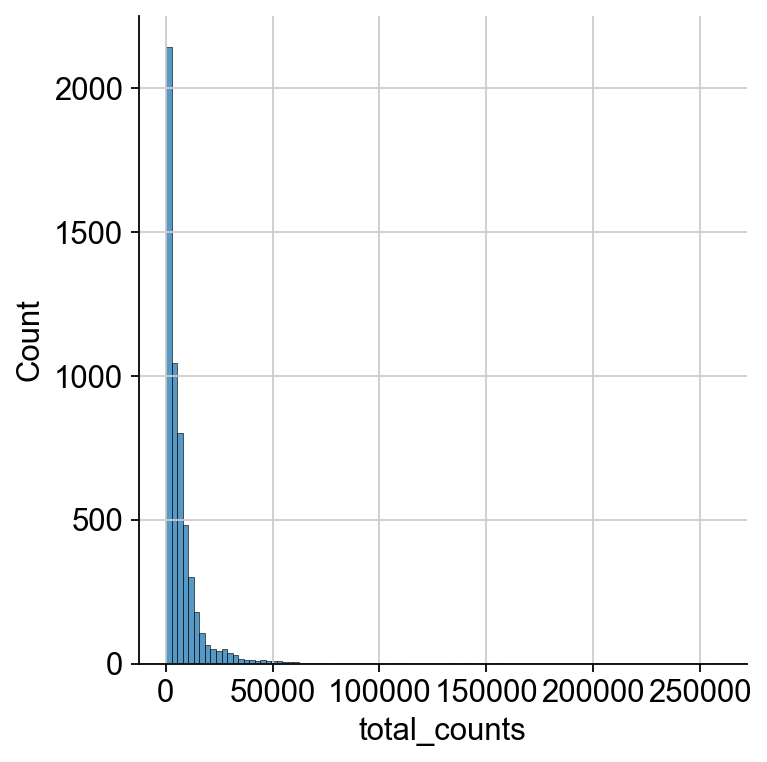

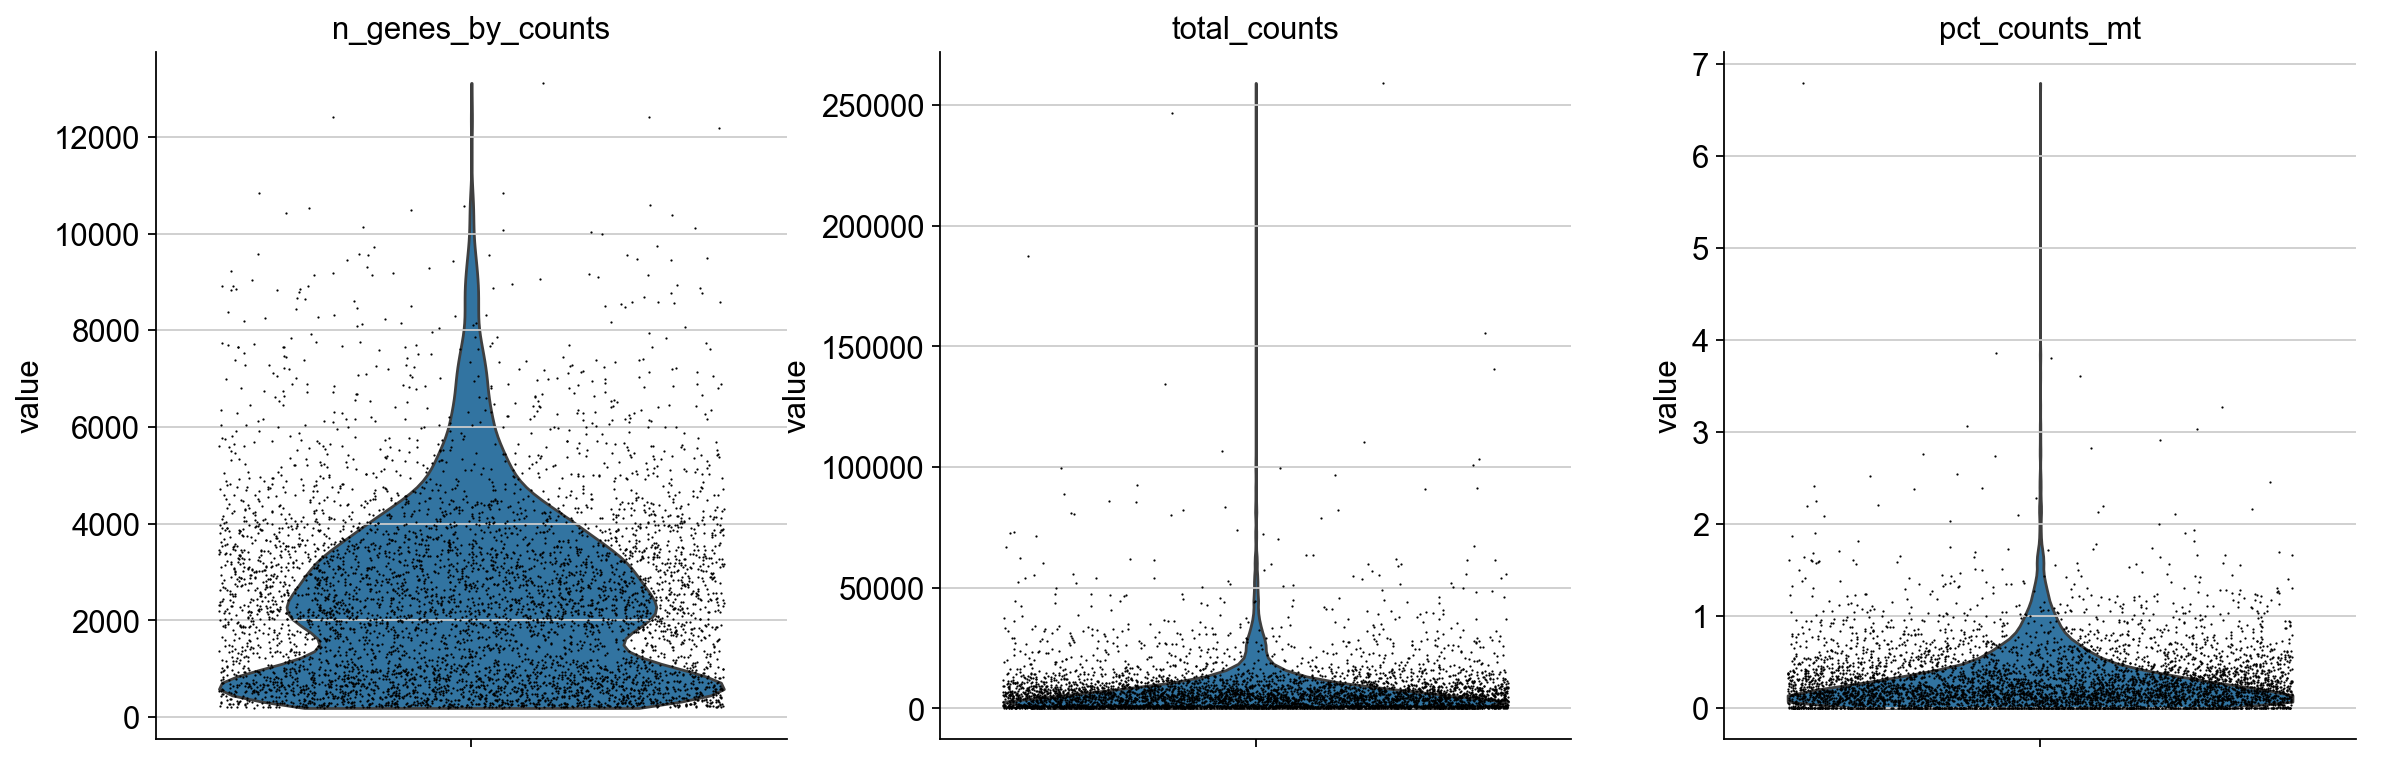

In [6]:
sns.displot(adata.obs["total_counts"], bins = 100, kde= False)
sc.pl.violin(adata,
             ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
             jitter= 0.4, # each dot is one cell/nucleus
             multi_panel= True)

In [7]:
# Calculating MAD (median absolute deviations) for filtering

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * st.median_abs_deviation(M)) | (np.median(M) + nmads * st.median_abs_deviation(M) < M)
    return outlier

# Defining whether a nucleus is an outlier based on mitochondrial
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5))
adata.obs.outlier.value_counts()

adata.obs["mt_outlier"] = (is_outlier(adata, "pct_counts_mt", 3)
                           | (adata.obs["pct_counts_mt"] > 0.6))
adata.obs.mt_outlier.value_counts()
adata

AnnData object with n_obs × n_vars = 5476 × 27586
    obs: 'sample', 'plate', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'plate_IDs', 'sample', 'project', 'tissue'

In [8]:
# Filtering
adata = adata[(~adata.obs["outlier"]) & (~adata.obs["mt_outlier"])].copy()

sc.pp.filter_cells(adata, min_genes= 100, inplace= True)
sc.pp.filter_genes(adata, min_cells= 20, inplace= True)

adata

AnnData object with n_obs × n_vars = 4543 × 21273
    obs: 'sample', 'plate', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'plate_IDs', 'sample', 'project', 'tissue'